<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/nodeFeatCorrGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torchvision
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.6.0+cu124
12.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    F

In [2]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time
import json
# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_sparse import spmm
# import pyg_lib
import torch_sparse
from torch_geometric.utils import to_networkx
from sklearn.metrics import f1_score

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid,Amazon
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch.profiler import profile, record_function, ProfilerActivity
import os.path as osp
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import accuracy_score
from transformers import AutoModelForCausalLM
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

def f1_micro(data, mask):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask.to(device)].cpu().numpy()
    return f1_score(y_true, y_pred, average='micro')


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Initial allocated memory: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

Initial allocated memory: 0.00 MB


In [5]:
num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

Using device: cpu


Processing...
Done!


Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [6]:


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


In [7]:
def train(data, mask):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(data, mask):
  model.eval()
  out = model(data.x.to(device), data.edge_index.to(device))
  pred = out.argmax(dim=1)
  correct = pred[mask.to(device)] == data.y[mask.to(device)]
  acc = int(correct.sum()) / int(mask.sum())
  return acc

In [8]:
import torch
from torch_geometric.utils import subgraph, to_networkx
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

def compute_corr_matrix(features):
    # features: [num_nodes, num_features] numpy array
    norm_features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)
    corr_matrix = cosine_similarity(norm_features)
    return corr_matrix

def select_least_correlated_nodes(nodes_idx, features_np, num_select):
    # nodes_idx: list of node indices (int) to consider neighbors for
    # features_np: numpy array of features of those nodes
    n = len(nodes_idx)
    corr_matrix = compute_corr_matrix(features_np)

    selected_indices = set()
    for i in range(n):
        # sort neighbors by ascending correlation (less correlated first)
        corr_values = corr_matrix[i]
        sorted_indices = np.argsort(np.abs(corr_values))  # abs because correlation ranges [-1,1]
        # remove self index
        sorted_indices = sorted_indices[sorted_indices != i]

        # select top-k least correlated neighbors (or all available)
        k = min(num_select, len(sorted_indices))
        for idx in sorted_indices[:k]:
            selected_indices.add(nodes_idx[idx])
    return list(selected_indices)

def custom_partition(data, num_neighbors=4, num_hops=2):
    all_nodes = set(range(data.num_nodes))
    used_nodes = set()
    subgraphs = []

    x_np = data.x.cpu().numpy()

    while len(used_nodes) < data.num_nodes:
        # Remaining nodes to pick from
        candidate_nodes = list(all_nodes - used_nodes)
        if not candidate_nodes:
            break

        # Pick a random seed node not used yet
        seed = np.random.choice(candidate_nodes)
        current_hop_nodes = [seed]
        selected_nodes = set([seed])  # Include starting node

        for hop in range(num_hops):
            neighbors = []
            # get neighbors of current hop nodes
            for node in current_hop_nodes:
                neigh = data.edge_index[1][data.edge_index[0] == node].cpu().numpy()
                neighbors.extend(neigh.tolist())
            neighbors = list(set(neighbors) - used_nodes - selected_nodes)
            if not neighbors:
                break

            # get features of neighbors and current hop nodes combined
            nodes_to_consider = current_hop_nodes + neighbors
            feats = x_np[nodes_to_consider]

            # select least correlated neighbors among neighbors
            selected_neighbors = select_least_correlated_nodes(neighbors, x_np[neighbors], num_neighbors)

            selected_nodes.update(selected_neighbors)
            current_hop_nodes = selected_neighbors

        used_nodes.update(selected_nodes)

        # Build subgraph with selected nodes
        sub_nodes = list(selected_nodes)
        edge_index_sub, _ = subgraph(sub_nodes, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)

        x_sub = data.x[sub_nodes]
        y_sub = data.y[sub_nodes]
        mask_sub = {}
        for key in ['train_mask', 'val_mask', 'test_mask']:
            if hasattr(data, key):
                mask = getattr(data, key)
                mask_sub[key] = mask[sub_nodes]

        subgraph_data = Data(
            x=x_sub,
            edge_index=edge_index_sub,
            y=y_sub,
            **mask_sub
        )
        subgraphs.append(subgraph_data)

    return subgraphs


In [85]:
subgraphs = custom_partition(data, num_neighbors=300, num_hops=64)

from torch_geometric.loader import DataLoader
loader = DataLoader(subgraphs, batch_size=128, shuffle=True)


In [9]:
data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)


Computing METIS partitioning...
Done!


In [10]:
def avg_neighbors_per_node(subgraphs):
    total_neighbors = 0
    total_nodes = 0

    for g in subgraphs:
        edge_index = g.edge_index
        num_nodes = g.num_nodes
        num_edges = edge_index.size(1)
        # Each edge connects two nodes, but we count for undirected graph
        total_neighbors += num_edges
        total_nodes += num_nodes

    avg = total_neighbors / total_nodes
    print(f"Average neighbors per node: {avg:.2f}")
    return avg



In [11]:
def train_batch(loader):
    model.train()
    total_loss = 0
    i = 1
    for sub_data in loader:
        sub_data = sub_data.to(device)
        batch_mem = sum(t.element_size() * t.nelement() for t in [sub_data.x, sub_data.edge_index, sub_data.y])
        #print(f"Batch {i}: {batch_mem/1024**2:.2f} MB cluster data")

        out = model(sub_data.x, sub_data.edge_index)
        #print(f"  + Forward pass: {torch.cuda.max_memory_allocated()/1024**2:.2f} MB")
        loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        i += 1
    return total_loss / i  # Optional: average loss


In [12]:
def estimate_subgraph_memory(subgraph):
    bytes_per_float = 4  # float32
    bytes_per_int = 4    # int32

    num_nodes = subgraph.num_nodes
    num_edges = subgraph.edge_index.size(1)
    num_features = subgraph.x.size(1)

    feature_memory = num_nodes * num_features * bytes_per_float
    edge_memory = 2 * num_edges * bytes_per_int
    label_memory = num_nodes * bytes_per_int

    total_memory_bytes = feature_memory + edge_memory + label_memory
    total_memory_MB = total_memory_bytes / (1024 ** 2)

    return total_memory_MB

memories = [estimate_subgraph_memory(g) for g in loader]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

Average subgraph memory: 38.36 MB


NameError: name 'subgraphs' is not defined

In [87]:

#model = GCN(hidden_channels=64).to(device)
model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  end_time = time.time()
  training.append(end_time - start_time)
  print(f"Training time: {end_time - start_time:.2f} seconds")


<IPython.core.display.Javascript object>

Memory after cleanup: 193.68 MB
Epoch: 010, Train Acc: 0.9000, Val Acc: 0.7400, Val F1 (micro): 0.7400
Epoch: 020, Train Acc: 0.9500, Val Acc: 0.7480, Val F1 (micro): 0.7480
Epoch: 030, Train Acc: 0.9667, Val Acc: 0.7640, Val F1 (micro): 0.7640
Epoch: 040, Train Acc: 0.9833, Val Acc: 0.7700, Val F1 (micro): 0.7700
Epoch: 050, Train Acc: 1.0000, Val Acc: 0.7880, Val F1 (micro): 0.7880
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.7740, Val F1 (micro): 0.7740
Epoch: 070, Train Acc: 1.0000, Val Acc: 0.7800, Val F1 (micro): 0.7800
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.7740, Val F1 (micro): 0.7740
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.7640, Val F1 (micro): 0.7640
Epoch: 100, Train Acc: 1.0000, Val Acc: 0.7660, Val F1 (micro): 0.7660
Training time: 0.96 seconds
Memory after cleanup: 193.36 MB
Epoch: 010, Train Acc: 1.0000, Val Acc: 0.7620, Val F1 (micro): 0.7620
Epoch: 020, Train Acc: 1.0000, Val Acc: 0.7620, Val F1 (micro): 0.7620
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.7680, Val F1 (

In [88]:
print(res)
print(sum(res)/10)

[0.757, 0.757, 0.761, 0.76, 0.759, 0.759, 0.761, 0.759, 0.759, 0.757]
0.7589


In [89]:
print(training)
print(sum(training)/10)

[0.9606695175170898, 0.8578195571899414, 0.8523299694061279, 0.8538804054260254, 0.8508808612823486, 0.8549938201904297, 0.8874640464782715, 1.0498828887939453, 0.9405148029327393, 0.8576340675354004]
0.8966069936752319


In [ ]:
test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

Test F1 Score (micro): 0.7790
Test test accuracy (micro):  0.7790


In [90]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


Allocated memory after tensor creation: 193.36 MB
Reserved memory after tensor creation: 340.00 MB
Peak allocated memory: 297.64 MB


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_pubmed_results.json", "w") as f:
    json.dump(metrics, f)

**cora dataset**

In [14]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
#subgraphs = custom_partition(data, num_neighbors=300, num_hops=64)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)


Using device: cpu


Computing METIS partitioning...
Done!


In [98]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 145.22 MB
Epoch: 010, Train Acc: 0.5500, Val Acc: 0.3040, Val F1 (micro): 0.3040
Epoch: 020, Train Acc: 0.8857, Val Acc: 0.6580, Val F1 (micro): 0.6580
Epoch: 030, Train Acc: 0.9857, Val Acc: 0.7460, Val F1 (micro): 0.7460
Epoch: 040, Train Acc: 0.9857, Val Acc: 0.7740, Val F1 (micro): 0.7740
Epoch: 050, Train Acc: 0.9929, Val Acc: 0.7960, Val F1 (micro): 0.7960
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.7920, Val F1 (micro): 0.7920
Epoch: 070, Train Acc: 1.0000, Val Acc: 0.7780, Val F1 (micro): 0.7780
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.7920, Val F1 (micro): 0.7920
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.7860, Val F1 (micro): 0.7860
Epoch: 100, Train Acc: 0.9929, Val Acc: 0.7860, Val F1 (micro): 0.7860
Training time: 2.24 seconds
Memory after cleanup: 145.93 MB
Epoch: 010, Train Acc: 0.9929, Val Acc: 0.7840, Val F1 (micro): 0.7840
Epoch: 020, Train Acc: 0.9929, Val Acc: 0.7880, Val F1 (micro): 0.7880
Epoch: 030, Train Acc: 0.9929, Val Acc: 0.7800, Val F1 (

In [99]:
print(res)
print(sum(res)/10)

[0.801, 0.792, 0.789, 0.787, 0.784, 0.784, 0.786, 0.782, 0.784, 0.785]
0.7874


In [100]:
print(training)
print(sum(training)/10)

[2.2379417419433594, 1.843902349472046, 1.8249516487121582, 1.80808687210083, 1.8024303913116455, 2.3058760166168213, 1.742635726928711, 1.8226909637451172, 1.791804552078247, 1.79359769821167]
1.8973917961120605


In [15]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in loader]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

Allocated memory after tensor creation: 0.00 MB
Reserved memory after tensor creation: 0.00 MB
Peak allocated memory: 0.00 MB
Average subgraph memory: 14.89 MB
Average neighbors per node: 3.84
Number of subgraphs: 149


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Cora_results.json", "w") as f:
    json.dump(metrics, f)

**citeser dataset**

In [16]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
#subgraphs = custom_partition(data, num_neighbors=300, num_hops=64)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)

Using device: cpu


Processing...
Done!
Computing METIS partitioning...
Done!


In [103]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 211.73 MB
Epoch: 010, Train Acc: 0.8167, Val Acc: 0.5100, Val F1 (micro): 0.5100
Epoch: 020, Train Acc: 0.9917, Val Acc: 0.6580, Val F1 (micro): 0.6580
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.6480, Val F1 (micro): 0.6480
Epoch: 040, Train Acc: 1.0000, Val Acc: 0.6340, Val F1 (micro): 0.6340
Epoch: 050, Train Acc: 1.0000, Val Acc: 0.6440, Val F1 (micro): 0.6440
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.6300, Val F1 (micro): 0.6300
Epoch: 070, Train Acc: 1.0000, Val Acc: 0.6260, Val F1 (micro): 0.6260
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.6320, Val F1 (micro): 0.6320
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.6340, Val F1 (micro): 0.6340
Epoch: 100, Train Acc: 1.0000, Val Acc: 0.6280, Val F1 (micro): 0.6280
Training time: 8.49 seconds
Memory after cleanup: 213.55 MB
Epoch: 010, Train Acc: 1.0000, Val Acc: 0.6160, Val F1 (micro): 0.6160
Epoch: 020, Train Acc: 1.0000, Val Acc: 0.6280, Val F1 (micro): 0.6280
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.6280, Val F1 (

In [17]:
print(res)
print(sum(res)/10)
print(training)
print(sum(training)/10)
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in loader]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")


NameError: name 'res' is not defined

In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_CiteSeer_results.json", "w") as f:
    json.dump(metrics, f)

**Amazon dataset**

In [19]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Amazon(
        root='data/Amazon',
        name='Computers',
        transform=T.Compose([
        NormalizeFeatures(),          # feature‑wise ℓ₂ normalisation
        RandomNodeSplit(              # ⇦ add a split transform
                split='train_rest',       # 10% val, 10% test by default
                num_val=0.1,
                num_test=0.1,
                num_splits=1,
            )
        ])
    )
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()

#subgraphs = custom_partition(data, num_neighbors=300, num_hops=64)

#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)

data = data.cpu()
cluster_data = ClusterData(data, num_parts=128)
loader = ClusterLoader(cluster_data, batch_size=128, shuffle=True)

Using device: cpu


Processing...
Done!
Computing METIS partitioning...
Done!


In [76]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 162.62 MB
Epoch: 010, Train Acc: 0.3763, Val Acc: 0.3738, Val F1 (micro): 0.3738
Epoch: 020, Train Acc: 0.3764, Val Acc: 0.3738, Val F1 (micro): 0.3738
Epoch: 030, Train Acc: 0.3781, Val Acc: 0.3738, Val F1 (micro): 0.3738
Epoch: 040, Train Acc: 0.3807, Val Acc: 0.3760, Val F1 (micro): 0.3760
Epoch: 050, Train Acc: 0.4269, Val Acc: 0.4349, Val F1 (micro): 0.4349
Epoch: 060, Train Acc: 0.4654, Val Acc: 0.4742, Val F1 (micro): 0.4742
Epoch: 070, Train Acc: 0.5406, Val Acc: 0.5411, Val F1 (micro): 0.5411
Epoch: 080, Train Acc: 0.5613, Val Acc: 0.5673, Val F1 (micro): 0.5673
Epoch: 090, Train Acc: 0.5920, Val Acc: 0.6029, Val F1 (micro): 0.6029
Epoch: 100, Train Acc: 0.6208, Val Acc: 0.6167, Val F1 (micro): 0.6167
Training time: 4.38 seconds
Memory after cleanup: 163.00 MB
Epoch: 010, Train Acc: 0.6470, Val Acc: 0.6407, Val F1 (micro): 0.6407
Epoch: 020, Train Acc: 0.6495, Val Acc: 0.6465, Val F1 (micro): 0.6465
Epoch: 030, Train Acc: 0.6456, Val Acc: 0.6356, Val F1 (

In [79]:
print(res)
print(sum(res)/10)
print(training)
print(sum(training)/10)
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in loader]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")


[0.6065454545454545, 0.8021818181818182, 0.8152727272727273, 0.8334545454545454, 0.8741818181818182, 0.8836363636363637, 0.8858181818181818, 0.8952727272727272, 0.8945454545454545, 0.893090909090909]
0.8384
[4.382862329483032, 4.053532123565674, 4.493819952011108, 3.9802539348602295, 3.9277055263519287, 4.641192197799683, 3.974245548248291, 4.0580735206604, 4.369818925857544, 3.941255569458008]
4.18227596282959
Allocated memory after tensor creation: 163.00 MB
Reserved memory after tensor creation: 514.00 MB
Peak allocated memory: 474.98 MB
Average subgraph memory: 14.68 MB
Average neighbors per node: 35.74
Number of subgraphs: 361


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Amazon_results.json", "w") as f:
    json.dump(metrics, f)

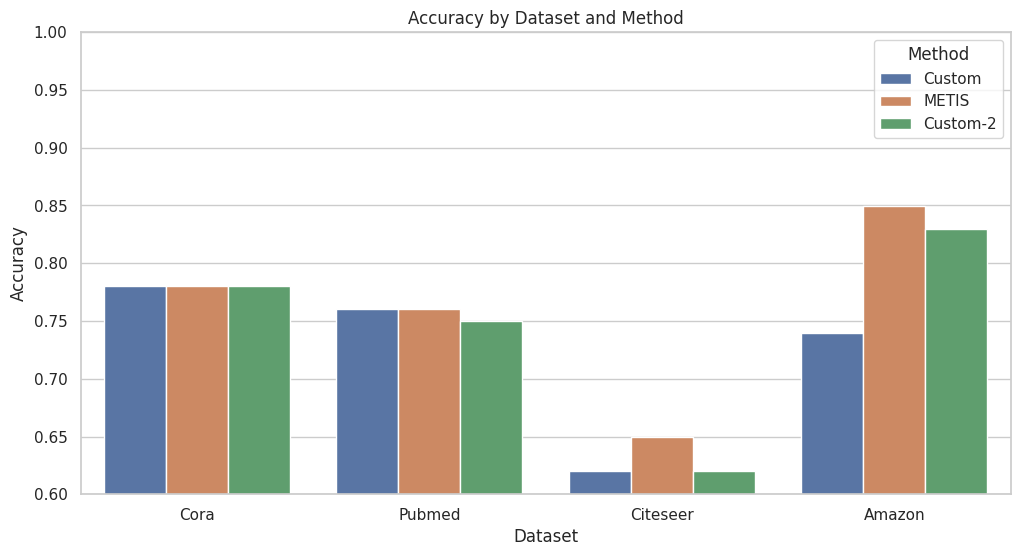

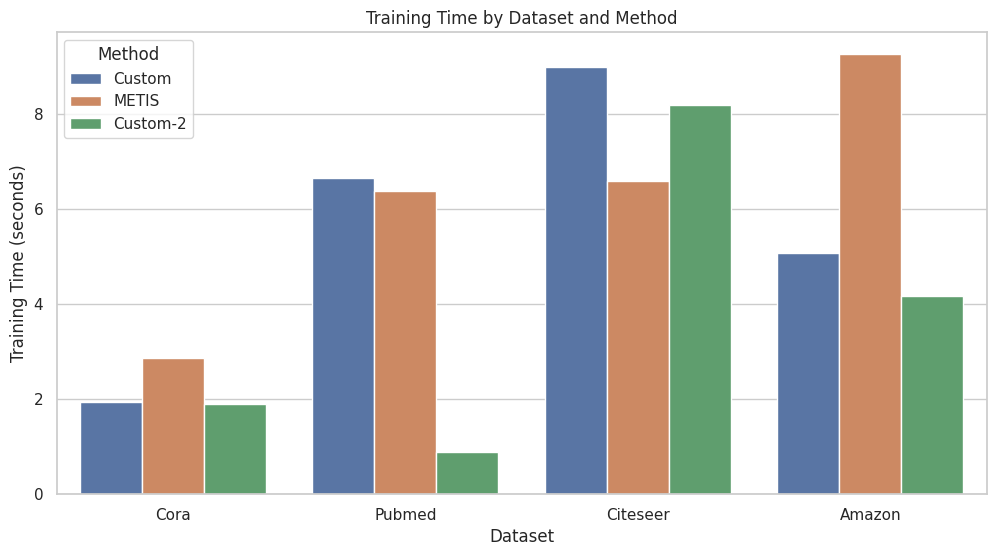

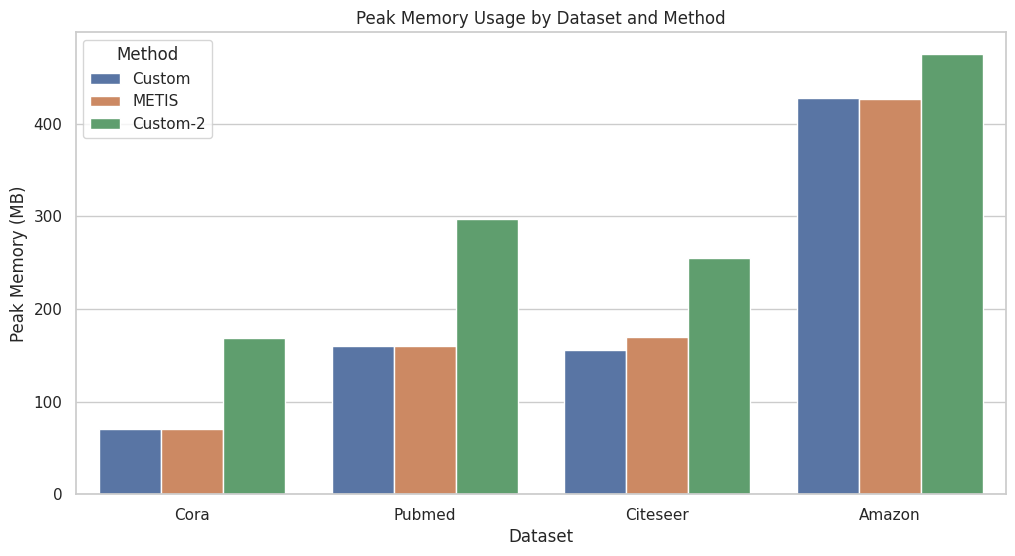

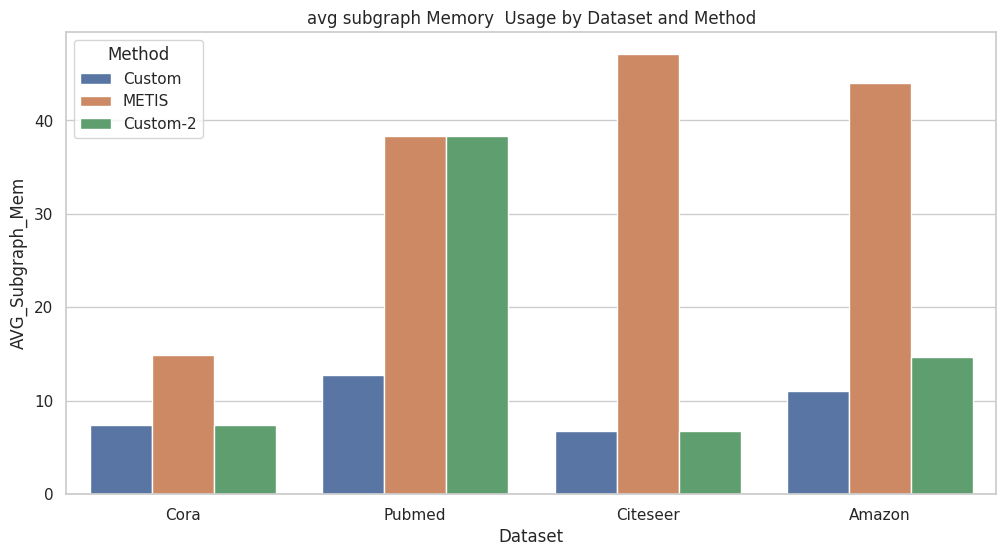

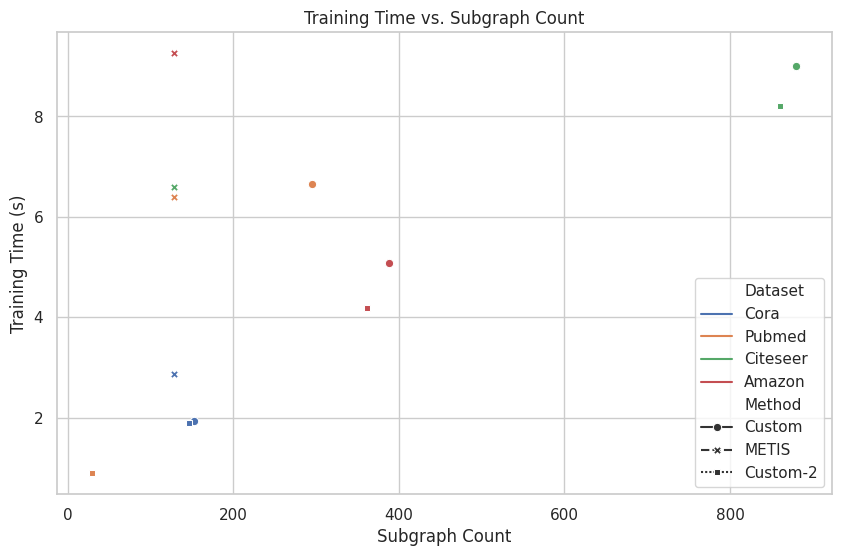

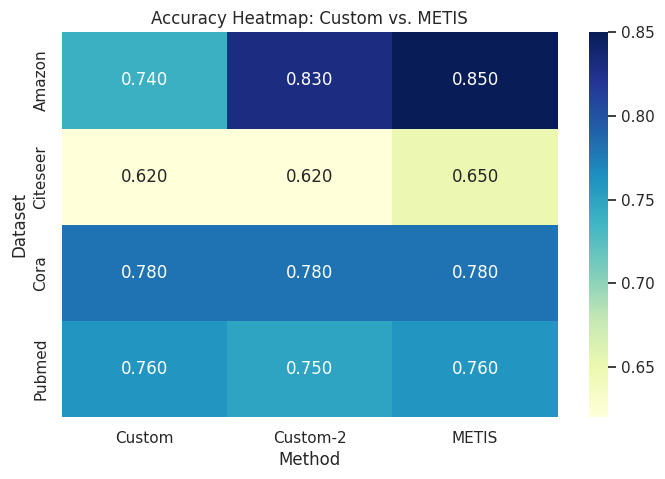

In [23]:
import pandas as pd

# Example results (replace with your actual values)
results = [
    # dataset, method, accuracy, training_time (s), peak_memory (MB), num_subgraphs, avg_subgraph_memory
    ("Cora", "Custom", 0.78, 1.94, 70.48, 152,7.45),
    ("Cora", "METIS", 0.78, 2.87, 70.69, 128, 14.89),
    ("Cora", "Custom-2", 0.78, 1.89, 168.80, 147, 7.45),

    ("Pubmed", "Custom", 0.76, 6.65, 159.85, 295,12.78),
    ("Pubmed", "METIS", 0.76, 6.39, 160.35, 128, 38.36),
    ("Pubmed", "Custom-2", 0.75, 0.89, 297.64, 29, 38.36),

    ("Citeseer", "Custom", 0.62, 9.00, 155.42, 880, 6.72),
    ("Citeseer", "METIS", 0.65, 6.60, 170.18, 128, 47.08),
    ("Citeseer", "Custom-2", 0.62, 8.20, 255.00, 860, 6.72),

    ("Amazon", "Custom", 0.74, 5.08, 427.28, 388, 11.01),
    ("Amazon", "Custom-2", 0.83, 4.18, 474.98, 361, 14.68),
    ("Amazon", "METIS", 0.85, 9.26, 426.65, 128, 44.04),
]

df = pd.DataFrame(results, columns=["Dataset", "Method", "Accuracy", "TrainingTime", "PeakMemory", "SubgraphCount", "AVG_Subgraph_Mem"])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="Accuracy", hue="Method")
plt.title("Accuracy by Dataset and Method")
plt.ylim(0.6, 1.0)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="TrainingTime", hue="Method")
plt.title("Training Time by Dataset and Method")
plt.ylabel("Training Time (seconds)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="PeakMemory", hue="Method")
plt.title("Peak Memory Usage by Dataset and Method")
plt.ylabel("Peak Memory (MB)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="AVG_Subgraph_Mem", hue="Method")
plt.title("avg subgraph Memory  Usage by Dataset and Method")
plt.ylabel("AVG_Subgraph_Mem")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SubgraphCount", y="TrainingTime", hue="Dataset", style="Method", markers=True)
plt.title("Training Time vs. Subgraph Count")
plt.xlabel("Subgraph Count")
plt.ylabel("Training Time (s)")
plt.show()
# Create pivot for heatmap
heatmap_df = df.pivot_table(index="Dataset", columns="Method", values="Accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap: Custom vs. METIS")
plt.show()


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create fake numeric data
np.random.seed(0)

features = data.x.cpu().numpy()  # Shape: (num_nodes, num_features)
df = pd.DataFrame(features)
# Step 2: Compute correlation/similarity matrices
df_numeric = df.select_dtypes(include=['number'])

correlations = {
    'Pearson': df_numeric.corr(method='pearson'),
    'Spearman': df_numeric.corr(method='spearman'),
    'Kendall': df_numeric.corr(method='kendall'),
    'Cosine': pd.DataFrame(
        cosine_similarity(df_numeric.T),
        index=df_numeric.columns,
        columns=df_numeric.columns
    )
}

# Step 3: Plot heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, (name, corr_matrix) in zip(axes, correlations.items()):
    sns.heatmap(corr_matrix, ax=ax, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar=False)
    ax.set_title(f'{name} Correlation Matrix', fontsize=14)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 